<h1>Measuring power spectra with pyproffit</h1>

<p>pyproffit is a Python3 package used here for extracting surface brightness profiles and computing model images. The power_spectrum class includes the tools for computing the power spectra from the results of pyproffit. </p>

In [1]:
import pyproffit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

In [2]:
# Loading images
dat=pyproffit.Data('../data/XCOP/A1644/mosaic_a1644.fits.gz',explink='../data/XCOP/A1644/mosaic_a1644_expo.fits.gz',bkglink='../data/XCOP/A1644/mosaic_a1644_bkg.fits.gz')

# Reading a region file to mask point sources and/or substructures

dat.region('../data/XCOP/A1644/src_ps.reg')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


Excluded 157 sources


<Figure size 432x288 with 0 Axes>

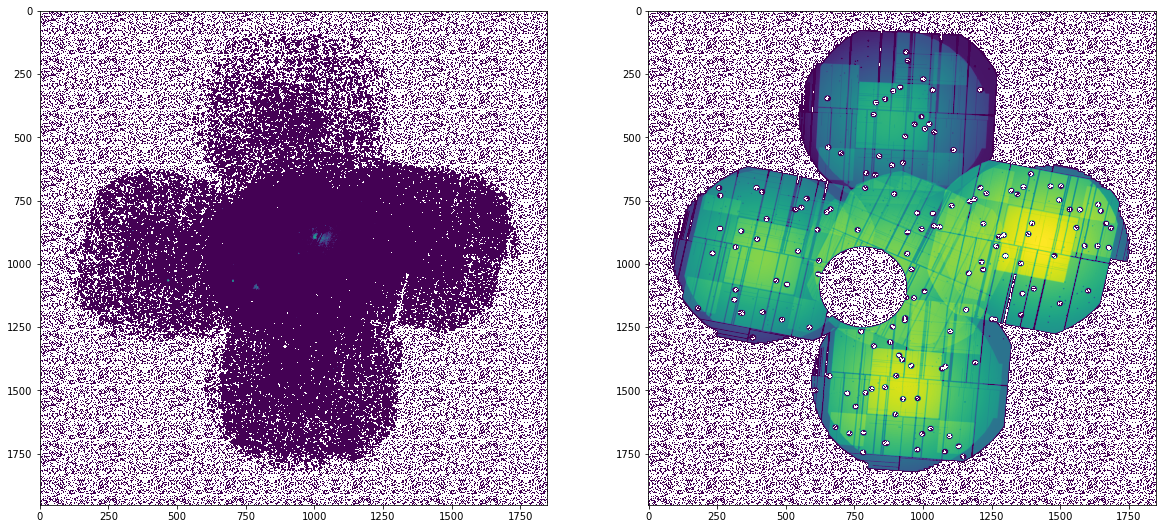

In [3]:
# Display the loaded data
plt.clf()
fig = plt.figure(figsize=(20, 20))
s1 = plt.subplot(221)
plt.imshow(dat.img,aspect='auto',norm=LogNorm())
plt.subplot(222)
plt.imshow(dat.exposure,aspect='auto',norm=LogNorm())
plt.show()



<h2>Brightness profile</h2>

<p>Now let's compute the centroid and ellipse ratios and extract a brightness profile</p>

<p>The class Profile is designed for that. The "method" argument specifies the choice of the center:
<blockquote>
<p> method=1: compute image centroid and ellipticity </p>
<p> method=2: use brightness peak </p>
<p> method=3 and method=4: use custom center in image coordinate (3) or FK5 (4), provided by the "centroid_ra" and "centroid_dec" arguments
</blockquote>
</p>

In [4]:
# Constructor of class Profile 
prof=pyproffit.Profile(dat,center_choice='centroid',maxrad=35.,binsize=10.) # Here we define the center as the image centroid

# Extract the brightness profile in elliptical annuli
# prof.ellratio and prof.ellangle contain the major-to-minor-axis ratio and rotation angle of the ellipse
prof.SBprofile(ellipse_ratio=prof.ellratio,rotation_angle=prof.ellangle+180.)


Computing centroid and ellipse parameters using principal component analysis
No approximate center provided, will search for the centroid within a radius of 40.6875 arcmin from the center of the image
Denoising image...
Running PCA...
Centroid position: 1008.5174086075358 912.6811669048168
Corresponding FK5 coordinates:  194.29675725561432 -17.39953222049076
Ellipse axis ratio and position angle: 1.032059250185465 -140.02587975075423



<h2>Now display the data...</h2>



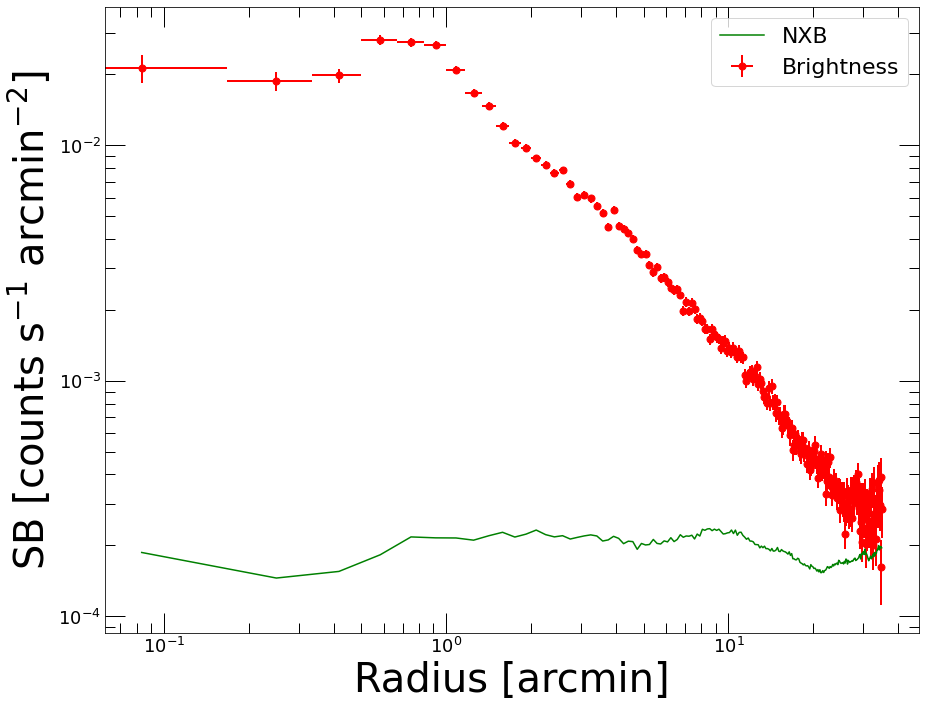

In [5]:
fig=plt.figure(figsize=(13,10))
ax_size = [0.1, 0.1,
          0.87, 0.87]
ax = fig.add_axes(ax_size)
axbox = ax.get_position()
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.xlabel('Radius [arcmin]',fontsize=40)
plt.ylabel('SB [counts s$^{-1}$ arcmin$^{-2}$]',fontsize=40)
plt.xscale('log')
plt.yscale('log')
plt.errorbar(prof.bins,prof.profile,xerr=prof.ebins,yerr=prof.eprof,fmt='o',color='red',elinewidth=2,markersize=7,capsize=0,
             mec='red',label='Brightness')
plt.plot(prof.bins,prof.bkgprof,color='green',label='NXB')
plt.legend(fontsize=22)
plt.show()


<h2>Fitting the data</h2>

<p>Now we define a model and fit the data. This is done with the "Model" and "Fitter" classes.</p>

In [6]:
# Define a model and construct a "Model" object
# There are currently few available models, but you can easily define a custom model
mod=pyproffit.Model(pyproffit.BetaModel)

# Construct a Fitter object by specifying model and data
fitobj=pyproffit.Fitter(mod,prof)

# Specify initial values for the parameters and fit the data
fitobj.Migrad(beta=0.7,rc=2.,norm=-2,bkg=-4,pedantic=False)


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 504.3                      │       Ncalls = 414 (414 total)       │
│ EDM = 5.14e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼─────────

In [7]:
# The results are stored in the Model structure
pars=mod.params
print(pars)
print(mod.errors)

[ 0.40320037  1.17879934 -1.5660823  -9.81899065]
[1.37031224e-03 3.38636727e-02 1.20015840e-02 5.68196004e+01]


In [8]:
# If instead of chi-squared we want to use C-stat
fitobj.Migrad(method='cstat',beta=0.7,rc=3.,norm=-2,bkg=-4,pedantic=False)


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 588.8                      │       Ncalls = 488 (488 total)       │
│ EDM = 3.68e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼─────────

<h2> Display the data and the fitted model</h2>


<Figure size 432x288 with 0 Axes>

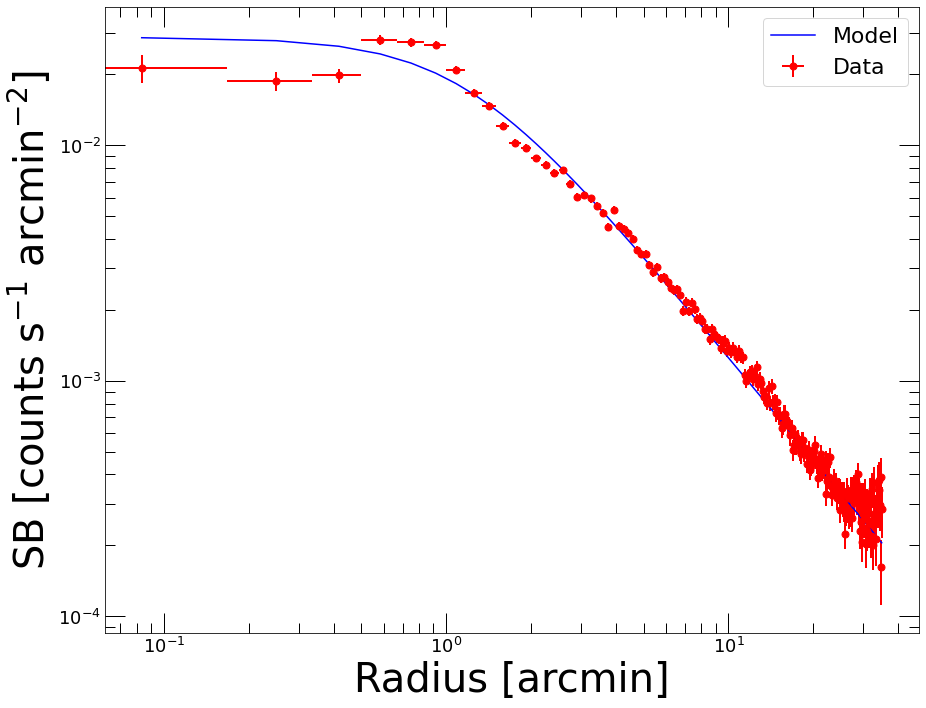

In [9]:
plt.clf()
fig=plt.figure(figsize=(13,10))
ax_size = [0.1, 0.1,
          0.87, 0.87]
ax = fig.add_axes(ax_size)
axbox = ax.get_position()
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right='on', top='on')
ax.tick_params(length=10, width=1, which='minor', direction='in', right='on', top='on')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.xlabel('Radius [arcmin]',fontsize=40)
plt.ylabel('SB [counts s$^{-1}$ arcmin$^{-2}$]',fontsize=40)
plt.xscale('log')
plt.yscale('log')
plt.errorbar(prof.bins,prof.profile,xerr=prof.ebins,yerr=prof.eprof,fmt='o',color='red',elinewidth=2,markersize=7,capsize=0,
             mec='red',label='Data')
tmod=mod.model(prof.bins,*mod.params)
plt.plot(prof.bins,tmod,color='blue',label='Model')
plt.legend(fontsize=22)
plt.show()

#It works!

In [10]:
# Save model image to output file, here 'test_outmod.fits'
prof.SaveModelImage(mod,'test_outmod.fits')


<h2>We are set to extract the power spectrum</h2>

<p>For this I just wrote a class called PowerSpectrum which in principle includes everything we need</p>


In [11]:
from pyproffit import power_spectrum
import importlib 
importlib.reload(power_spectrum)

# Class constructor, takes as input the "Data" and "Profiles" structures defined above
psc=power_spectrum.PowerSpectrum(dat,prof)



<p> </p>

<p> First we need to convolve the images with the Mexican Hat filter following Arevalo et al. 2012 and Churazov et al. 2012. This allows to account for CCD gaps and non-periodic box size.</p>

<p> The MexicanHat function does this. To speed up the computation it requires to specify the size of the region of interest such that we don't waste time convolving useless areas. The parameters to be given are the following:</p>
<blockquote>
<p> modimg_file: FITS file containing model image, created above</p>
<p> z: source redshift</p>
<p> region_size (default = 1): radius of the region of interest in Mpc</p>
<p> factshift (default = 1.5): "border" size to avoid border effects. The box will have a size of 2*region_size*factshift</p>
</blockquote>
<p> </p>


In [12]:
psc.MexicanHat(modimg_file='test_outmod.fits',z=0.0766,region_size=0.5,factshift=0.5)

Convolving with scale 2.0
Convolving with scale 2.953025502768465
Convolving with scale 4.360179810000473
Convolving with scale 6.4378610877937765
Convolving with scale 9.50558398776788
Convolving with scale 14.035115967293054
Convolving with scale 20.723027692864644
Convolving with scale 30.59781463580321
Convolving with scale 45.17806347425455
Convolving with scale 66.7059868025831


<p> </p>

<p> Now we extract the power spectrum from a circle or annulus in the region of interest using the PS function:
<blockquote>
<p> z: redshift</p>
<p> region_size (default=1): radius of the region of interest, must coincide with the value given for MexicanHat</p>
<p> radius_in (default=0), radius_out (default=1): inner and outer radii of the annulus (circle if radius_in=0) from which the power spectrum will be extracted </p>
</blockquote>
</p>

In [13]:
psc.PS(z=0.0766, region_size=0.5)


# Save the output to file 'test_out.txt'
psc.Save('test_out.txt')


Computing the power at scale 7.495579092169855 kpc
Computing the power at scale 11.06731810859784 kpc
Computing the power at scale 16.34103631097034 kpc
Computing the power at scale 24.127748483980458 kpc
Computing the power at scale 35.62492829878874 kpc
Computing the power at scale 52.60066090031056 kpc
Computing the power at scale 77.66554655054657 kpc
Computing the power at scale 114.67416982510767 kpc
Computing the power at scale 169.3178740011725 kpc
Computing the power at scale 250.00000000000009 kpc
Computing the covariance matrix...
Eigenvalues:  [5.35352468e+02 2.97159547e+01 1.78371542e+01 7.20314492e+00
 1.44471308e+00 1.59137519e-01 5.22921542e-02 1.39684341e-04
 2.65860795e-03 1.59589958e-03]



<h2> Plot the results </h2>


<Figure size 432x288 with 0 Axes>

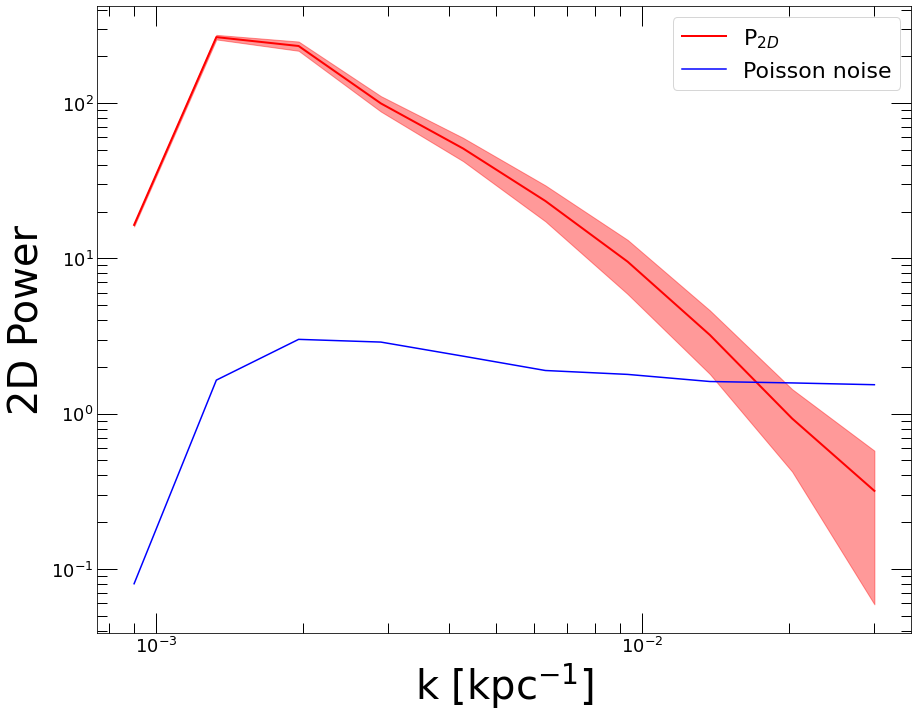

<Figure size 432x288 with 0 Axes>

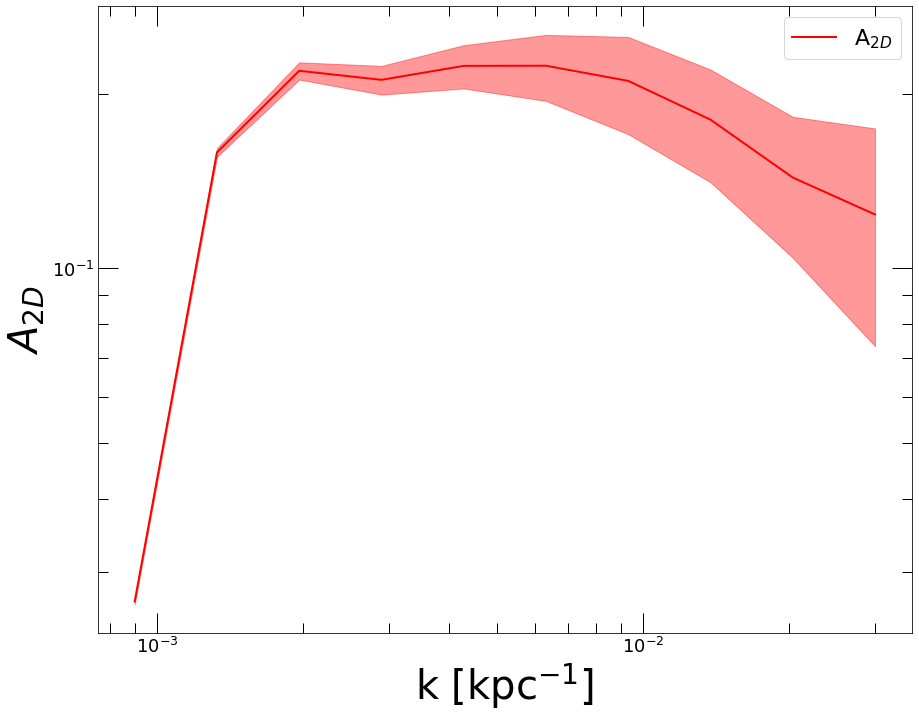

In [14]:
psc.Plot(save_plots=False)



<h2> Projection Factor </h2>

<p> The last step is to compue the projection factor between 2D and 3D spectra. Here I do it by simulating a fluctuation field with a Kolmogorov power spectrum, adding the fluctuation on top of the fitted 3D model and projecting the result. Then I compute the power spectrum in 2D and take the ratio of 2D to 3D as a function of wave number.</p>

<p> This is a lengthy operation and it requires a lot of memory for large image sizes (it's 3D...). However I noticed that the projection factor depends ~linearly on the box size, so it is in principle possible to compute it for small box sizes and extrapolate. Otherwise we need to rebin the images.</p>

<p> Here I provide in the PowerSpectrum class the ProjectionFactor function that computes the projection factor for a given box size:
<blockquote>
<p> z: redshift</p>
<p> betaparams: array containing the best-fitting model results, see above; currently works only for BetaModel and DoubleBeta.</p>
<p> region_size (default=1): radius of the region of interest in Mpc </p>
</blockquote>
</p>

In [15]:
from importlib import reload
reload(power_spectrum)
pfact=psc.ProjectionFactor(z=0.0766,betaparams=pars,region_size=0.2)

We will use a single beta profile
Initializing 3D k-space ... 
Initializing fluctuations in the k-space ... 
Computing inverse 3D FFT  ... 
RMS (= 1 sigma) delta_x is:  2.533499797396932e-06
Minimum (real) delta_x/rms is:  -4.809704347229679
Maximum (real) delta_x/rms is:  4.512061020820037
3D fluctuations field saved to fluctuations.fits
Now computing 2D and 3D power spectra...
Convolving images with Mexican Hat filters
Convolving with scale  2.0
Convolving with scale  2.6671757942413916
Convolving with scale  3.5569133586935986
Convolving with scale  4.7434566062607075
Convolving with scale  6.32581632062649
Convolving with scale  8.436032084596059
Convolving with scale  11.250190287739175
Convolving with scale  15.003117608033763
Convolving with scale  20.007976061152235
Convolving with scale  26.682394721033234
Computing 2D and 3D power spectra...
Results written in file conv2d3d.txt
 Total computing time is:  0.2263575514157613  minutes


<Figure size 432x288 with 0 Axes>

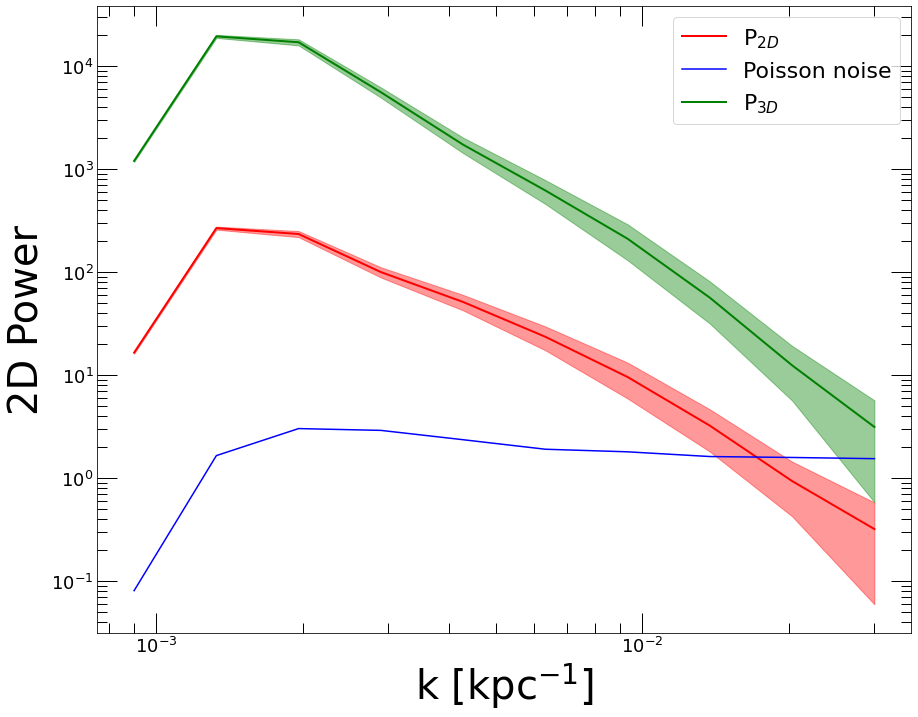

<Figure size 432x288 with 0 Axes>

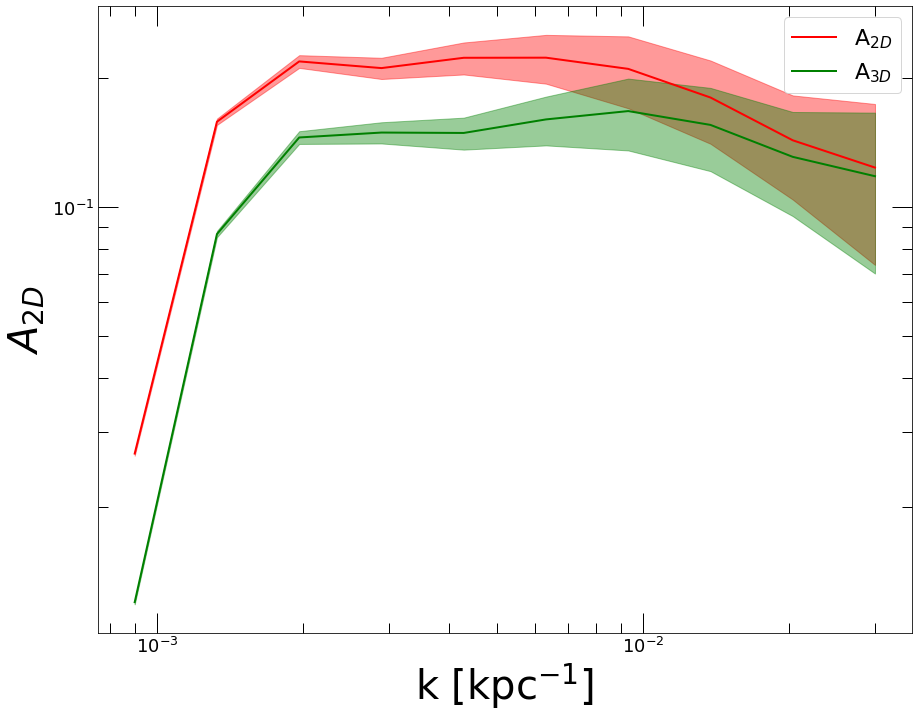

In [16]:
psc.Plot(save_plots=False,plot_3d=True,cfact=pfact)